In [2]:
import json
import nltk
import random 
import time
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr 
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model,load_model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D


In [3]:
with open('/media/revanth/Data/NLP_R/archive/Intent.json') as content2:
    data2=json.load(content2)
    
    

In [4]:
tags=[]
inputs=[]
responses={}
words=[]
classes=[]
documents=[]
ignore_words=['?','!']

for intent in data2['intents']:
    responses[intent['intent']]=intent['responses']
    for lines in intent['text']:
        inputs.append(lines)
        tags.append(intent['intent'])
        for pattern in intent['text']:
            w=nltk.word_tokenize(pattern)
            words.extend(w)
            documents.append((w,intent['intent']))
            if intent['intent'] not in classes:
                classes.append(intent['intent'])
data=pd.DataFrame({"patterns":inputs,"tags":tags})

In [5]:
data

,patterns,tags
0,Hi,Greeting
1,Hi there,Greeting
2,Hola,Greeting
3,Hello,Greeting
4,Hello there,Greeting
...,...,...
138,Can you prove you have a conscious,SelfAware
139,Can you prove you are self-aware please,SelfAware
140,Can you prove you are self aware please,SelfAware
141,Can you prove you have a conscious please,SelfAware


In [6]:
data['patterns']=data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns']=data['patterns'].apply(lambda wrd:''.join(wrd))

In [7]:
lemmatizer = WordNetLemmatizer()

In [8]:
words=[lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words=sorted(list(set(words)))

In [9]:
print(len(words),words)

117 ["'s", ',', 'a', 'about', 'adam', 'adios', 'am', 'any', 'anyone', 'are', 'aware', 'bay', 'be', 'bella', 'bored', 'by', 'bye', 'call', 'camera', 'can', 'cheering', 'clever', 'communicating', 'comprendo', 'conscious', 'could', 'do', 'doing', 'door', 'enough', 'for', 'friend', 'fuck', 'genious', 'get', 'girl', 'give', 'good', 'goodbye', 'gossip', 'got', 'great', 'have', 'hear', 'hello', 'help', 'helpful', 'hi', 'hola', 'hope', 'how', 'hya', 'i', 'identify', 'in', 'intelligent', 'is', 'it', 'joke', 'know', 'later', 'laugh', 'make', 'me', 'mean', 'meant', 'more', 'my', "n't", 'name', 'need', 'not', 'off', 'ok', 'open', 'please', 'pod', 'prove', 'quiet', 'real', 'saying', 'see', 'self', 'self-aware', 'shhh', 'shit', 'shut', 'some', 'speaking', 'stop', 'surely', 'talking', 'tell', 'thank', 'thanks', 'that', 'the', 'there', 'think', 'this', 'time', 'to', 'twat', 'understand', 'up', 'user', 'very', 'wa', 'want', 'well', 'what', 'who', 'why', 'will', 'with', 'you', 'your']


In [10]:
classes=sorted(list(set(classes)))
print(len(classes),classes)

22 ['Clever', 'CourtesyGoodBye', 'CourtesyGreeting', 'CourtesyGreetingResponse', 'CurrentHumanQuery', 'GoodBye', 'Gossip', 'Greeting', 'GreetingResponse', 'Jokes', 'NameQuery', 'NotTalking2U', 'PodBayDoor', 'PodBayDoorResponse', 'RealNameQuery', 'SelfAware', 'Shutup', 'Swearing', 'Thanks', 'TimeQuery', 'UnderstandQuery', 'WhoAmI']


In [11]:
print(len(documents))

951


In [12]:
tokenizer=Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train=tokenizer.texts_to_sequences(data['patterns'])

In [13]:
train

[[48],
 [48, 49],
 [63],
 [38],
 [38, 49],
 [64],
 [64, 49],
 [28, 39, 2, 20],
 [40, 2, 20],
 [5, 12, 20],
 [29, 2, 20],
 [28, 39, 2, 21],
 [40, 2, 21],
 [5, 12, 21],
 [29, 2, 21],
 [30, 4, 1],
 [48, 30, 4, 1],
 [38, 30, 4, 1],
 [63, 30, 4, 1],
 [30, 4, 1, 50],
 [65, 1, 4, 50, 51],
 [38, 65, 1, 4, 50, 51],
 [34, 8, 28, 39, 2, 20],
 [34, 8, 40, 2, 20],
 [34, 8, 5, 12, 20],
 [34, 8, 29, 2, 20],
 [41, 8, 28, 39, 2, 21],
 [41, 8, 40, 2, 21],
 [41, 8, 5, 12, 21],
 [41, 8, 29, 2, 21],
 [6, 2, 28, 11],
 [6, 9, 1, 35, 3],
 [42, 9, 1, 66, 5, 12],
 [6, 9, 1, 66, 5, 12],
 [42, 4, 1, 31, 23],
 [6, 11, 9, 1, 35, 3, 81],
 [15, 3, 28, 11],
 [6, 2, 14, 11],
 [6, 82, 5, 35, 1],
 [6, 10, 5, 35, 1],
 [6, 9, 14, 83, 35, 1],
 [42, 4, 1],
 [15, 3, 14, 11],
 [6, 2, 14, 24, 11],
 [6, 2, 14, 24, 11, 13],
 [67, 14, 24, 11],
 [15, 3, 14, 24, 11],
 [14, 24, 11],
 [14, 24, 11, 13],
 [14, 24, 11, 13],
 [6, 2, 7, 25],
 [67, 7, 25],
 [9, 1, 36, 6, 25, 29, 2],
 [9, 1, 36, 7, 25],
 [10, 1, 15, 3, 7, 25],
 [15, 3, 6, 25

In [14]:
X_train=pad_sequences(train)

In [15]:
X_train

array([[ 0,  0,  0, ...,  0,  0, 48],
       [ 0,  0,  0, ...,  0, 48, 49],
       [ 0,  0,  0, ...,  0,  0, 63],
       ...,
       [ 0, 10,  1, ..., 79, 80, 13],
       [ 0, 10,  1, ..., 16, 62, 13],
       [ 0,  0,  0, ..., 61, 16, 62]], dtype=int32)

In [16]:
le=LabelEncoder()
y_train=le.fit_transform(data['tags'])

In [17]:
y_train

array([ 7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  2,  2,
        2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
        4,  4,  4, 10, 10, 10, 10, 10, 10, 14, 14, 14, 14, 14, 14, 14, 19,
       19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 18, 11, 11, 11, 11, 11,
       11, 11, 20, 20, 20, 20, 20, 20, 16, 16, 16, 16, 16, 16, 16, 17, 17,
       17, 17,  5,  5,  5,  5,  1,  1,  1,  1,  1,  1, 21, 21, 21, 21, 21,
       21,  0,  0,  0,  0,  0,  0,  0,  6,  6,  6,  6,  6,  6,  9,  9,  9,
        9,  9,  9, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13,
       15, 15, 15, 15, 15, 15, 15])

In [18]:
input_shape=X_train.shape[1]

In [19]:
input_shape

9

In [20]:
vocabulary=len(tokenizer.word_index)
print("Number of unique words : ",vocabulary)

output_length=le.classes_.shape[0]
print("output length :",output_length)

Number of unique words :  117
output length : 22


In [21]:
pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

In [22]:
pickle.dump(le,open('le.pkl','wb'))
pickle.dump(tokenizer,open('tokenizer.pkl','wb'))

In [23]:
i=Input(shape=(input_shape,))
x=Embedding(vocabulary+1,10)(i)
x=LSTM(10,return_sequences=True)(x)
x=Flatten()(x)
x=Dense(output_length,activation="softmax")(x)
model=Model(i,x)

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

2023-02-25 12:43:11.259912: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-25 12:43:11.259934: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-25 12:43:11.259954: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kali): /proc/driver/nvidia/version does not exist
2023-02-25 12:43:11.260165: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
plot_model(model, to_file='model1_plot.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 embedding (Embedding)       (None, 9, 10)             1180      
                                                                 
 lstm (LSTM)                 (None, 9, 10)             840       
                                                                 
 flatten (Flatten)           (None, 90)                0         
                                                                 
 dense (Dense)               (None, 22)                2002      
                                                                 
Total params: 4,022
Trainable params: 4,022
Non-trainable params: 0
_________________________________________________________________


In [26]:
train=model.fit(X_train,y_train,epochs=600)

Epoch 1/600
5/5 [==============================] - 2s 5ms/step - loss: 3.0925 - accuracy: 0.0559
Epoch 2/600
5/5 [==============================] - 0s 5ms/step - loss: 3.0888 - accuracy: 0.0699
Epoch 3/600
5/5 [==============================] - 0s 5ms/step - loss: 3.0859 - accuracy: 0.1049
Epoch 4/600
5/5 [==============================] - 0s 6ms/step - loss: 3.0831 - accuracy: 0.1049
Epoch 5/600
5/5 [==============================] - 0s 5ms/step - loss: 3.0802 - accuracy: 0.1049
Epoch 6/600
5/5 [==============================] - 0s 5ms/step - loss: 3.0771 - accuracy: 0.1119
Epoch 7/600
5/5 [==============================] - 0s 6ms/step - loss: 3.0735 - accuracy: 0.1329
Epoch 8/600
5/5 [==============================] - 0s 5ms/step - loss: 3.0694 - accuracy: 0.1329
Epoch 9/600
5/5 [==============================] - 0s 6ms/step - loss: 3.0648 - accuracy: 0.1329
Epoch 10/600
5/5 [==============================] - 0s 5ms/step - loss: 3.0594 - accuracy: 0.1399
Epoch 11/600
5/5 [===========

5/5 [==============================] - 0s 5ms/step - loss: 0.9432 - accuracy: 0.8671
Epoch 85/600
5/5 [==============================] - 0s 5ms/step - loss: 0.9262 - accuracy: 0.8392
Epoch 86/600
5/5 [==============================] - 0s 6ms/step - loss: 0.9201 - accuracy: 0.8531
Epoch 87/600
5/5 [==============================] - 0s 5ms/step - loss: 0.9077 - accuracy: 0.8462
Epoch 88/600
5/5 [==============================] - 0s 5ms/step - loss: 0.8993 - accuracy: 0.8671
Epoch 89/600
5/5 [==============================] - 0s 5ms/step - loss: 0.8823 - accuracy: 0.8601
Epoch 90/600
5/5 [==============================] - 0s 5ms/step - loss: 0.8690 - accuracy: 0.8601
Epoch 91/600
5/5 [==============================] - 0s 5ms/step - loss: 0.8590 - accuracy: 0.8671
Epoch 92/600
5/5 [==============================] - 0s 6ms/step - loss: 0.8545 - accuracy: 0.8462
Epoch 93/600
5/5 [==============================] - 0s 6ms/step - loss: 0.8375 - accuracy: 0.8601
Epoch 94/600
5/5 [===============

5/5 [==============================] - 0s 6ms/step - loss: 0.3648 - accuracy: 0.9650
Epoch 168/600
5/5 [==============================] - 0s 5ms/step - loss: 0.3551 - accuracy: 0.9790
Epoch 169/600
5/5 [==============================] - 0s 6ms/step - loss: 0.3510 - accuracy: 0.9790
Epoch 170/600
5/5 [==============================] - 0s 6ms/step - loss: 0.3472 - accuracy: 0.9790
Epoch 171/600
5/5 [==============================] - 0s 6ms/step - loss: 0.3425 - accuracy: 0.9790
Epoch 172/600
5/5 [==============================] - 0s 5ms/step - loss: 0.3450 - accuracy: 0.9790
Epoch 173/600
5/5 [==============================] - 0s 5ms/step - loss: 0.3376 - accuracy: 0.9720
Epoch 174/600
5/5 [==============================] - 0s 5ms/step - loss: 0.3361 - accuracy: 0.9790
Epoch 175/600
5/5 [==============================] - 0s 5ms/step - loss: 0.3337 - accuracy: 0.9790
Epoch 176/600
5/5 [==============================] - 0s 5ms/step - loss: 0.3296 - accuracy: 0.9790
Epoch 177/600
5/5 [=====

5/5 [==============================] - 0s 6ms/step - loss: 0.1732 - accuracy: 0.9860
Epoch 250/600
5/5 [==============================] - 0s 6ms/step - loss: 0.1690 - accuracy: 0.9860
Epoch 251/600
5/5 [==============================] - 0s 6ms/step - loss: 0.1660 - accuracy: 0.9860
Epoch 252/600
5/5 [==============================] - 0s 6ms/step - loss: 0.1664 - accuracy: 0.9860
Epoch 253/600
5/5 [==============================] - 0s 6ms/step - loss: 0.1649 - accuracy: 0.9860
Epoch 254/600
5/5 [==============================] - 0s 5ms/step - loss: 0.1681 - accuracy: 0.9860
Epoch 255/600
5/5 [==============================] - 0s 5ms/step - loss: 0.1677 - accuracy: 0.9860
Epoch 256/600
5/5 [==============================] - 0s 5ms/step - loss: 0.1622 - accuracy: 0.9860
Epoch 257/600
5/5 [==============================] - 0s 5ms/step - loss: 0.1589 - accuracy: 0.9860
Epoch 258/600
5/5 [==============================] - 0s 5ms/step - loss: 0.1592 - accuracy: 0.9860
Epoch 259/600
5/5 [=====

5/5 [==============================] - 0s 6ms/step - loss: 0.0917 - accuracy: 1.0000
Epoch 332/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0918 - accuracy: 1.0000
Epoch 333/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0912 - accuracy: 1.0000
Epoch 334/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0903 - accuracy: 1.0000
Epoch 335/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0893 - accuracy: 1.0000
Epoch 336/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0884 - accuracy: 1.0000
Epoch 337/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0880 - accuracy: 1.0000
Epoch 338/600
5/5 [==============================] - 0s 6ms/step - loss: 0.0873 - accuracy: 1.0000
Epoch 339/600
5/5 [==============================] - 0s 6ms/step - loss: 0.0866 - accuracy: 1.0000
Epoch 340/600
5/5 [==============================] - 0s 6ms/step - loss: 0.0871 - accuracy: 1.0000
Epoch 341/600
5/5 [=====

5/5 [==============================] - 0s 6ms/step - loss: 0.0555 - accuracy: 1.0000
Epoch 414/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0550 - accuracy: 1.0000
Epoch 415/600
5/5 [==============================] - 0s 6ms/step - loss: 0.0549 - accuracy: 1.0000
Epoch 416/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0544 - accuracy: 1.0000
Epoch 417/600
5/5 [==============================] - 0s 6ms/step - loss: 0.0541 - accuracy: 1.0000
Epoch 418/600
5/5 [==============================] - 0s 6ms/step - loss: 0.0537 - accuracy: 1.0000
Epoch 419/600
5/5 [==============================] - 0s 6ms/step - loss: 0.0533 - accuracy: 1.0000
Epoch 420/600
5/5 [==============================] - 0s 6ms/step - loss: 0.0531 - accuracy: 1.0000
Epoch 421/600
5/5 [==============================] - 0s 6ms/step - loss: 0.0526 - accuracy: 1.0000
Epoch 422/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0526 - accuracy: 1.0000
Epoch 423/600
5/5 [=====

5/5 [==============================] - 0s 5ms/step - loss: 0.0359 - accuracy: 1.0000
Epoch 496/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0355 - accuracy: 1.0000
Epoch 497/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0354 - accuracy: 1.0000
Epoch 498/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0352 - accuracy: 1.0000
Epoch 499/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0351 - accuracy: 1.0000
Epoch 500/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0348 - accuracy: 1.0000
Epoch 501/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0348 - accuracy: 1.0000
Epoch 502/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0345 - accuracy: 1.0000
Epoch 503/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0346 - accuracy: 1.0000
Epoch 504/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0342 - accuracy: 1.0000
Epoch 505/600
5/5 [=====

5/5 [==============================] - 0s 5ms/step - loss: 0.0245 - accuracy: 1.0000
Epoch 578/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0243 - accuracy: 1.0000
Epoch 579/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0242 - accuracy: 1.0000
Epoch 580/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0242 - accuracy: 1.0000
Epoch 581/600
5/5 [==============================] - 0s 6ms/step - loss: 0.0240 - accuracy: 1.0000
Epoch 582/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0239 - accuracy: 1.0000
Epoch 583/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0239 - accuracy: 1.0000
Epoch 584/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0237 - accuracy: 1.0000
Epoch 585/600
5/5 [==============================] - 0s 5ms/step - loss: 0.0236 - accuracy: 1.0000
Epoch 586/600
5/5 [==============================] - 0s 6ms/step - loss: 0.0235 - accuracy: 1.0000
Epoch 587/600
5/5 [=====

In [27]:
model.save("chat_2.h5")

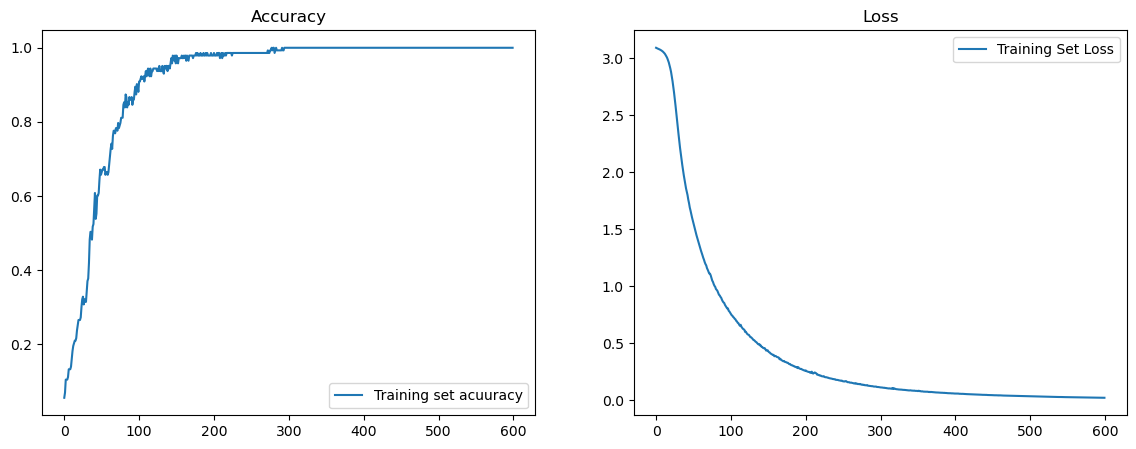

In [28]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(train.history['accuracy'],label="Training set acuuracy")
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [ ]:
while True:
    texts_p = []
    prediction_input = input('👨‍🦰 YOU : ')
  
  # Menghapus punktuasi dan konversi ke huruf kecil
    prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input = ''.join(prediction_input)
    texts_p.append(prediction_input)

  # Tokenisasi dan Padding
    prediction_input = tokenizer.texts_to_sequences(texts_p)
    prediction_input = np.array(prediction_input).reshape(-1)
    prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model 
    output = model.predict(prediction_input)
    output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan voice bot
    response_tag = le.inverse_transform([output])[0]
    print("🤖 AIBot : ", random.choice(responses[response_tag]))
    #tts = gTTS(random.choice(responses[response_tag]), lang='id')
  # Simpan model voice bot ke dalam Google Drive
    #tts.save('KadekBot.wav')
    #time.sleep(0.08)
  # Load model voice bot from Google Drive
    #ipd.display(ipd.Audio('KadekBot.wav', autoplay=False))
    #print("="*60 + "\n")
  # Tambahkan respon 'goodbye' agar bot bisa berhenti
    if response_tag == "goodbye":
        break 

👨‍🦰 YOU : HOW are yoou
1/1 [==============================] - 0s 279ms/step
🤖 AIBot :  I am sorry to disturb you
👨‍🦰 YOU : HI 
1/1 [==============================] - 0s 16ms/step
🤖 AIBot :  Hola human, please tell me your GeniSys user
👨‍🦰 YOU : hello
1/1 [==============================] - 0s 16ms/step
🤖 AIBot :  Hola human, please tell me your GeniSys user
👨‍🦰 YOU : good
1/1 [==============================] - 0s 16ms/step
🤖 AIBot :  See you later
👨‍🦰 YOU : what is your name
1/1 [==============================] - 0s 15ms/step
🤖 AIBot :  You can call me Geni
👨‍🦰 YOU : hence your an AI bot
1/1 [==============================] - 0s 17ms/step
🤖 AIBot :  See you later
👨‍🦰 YOU : good bye
1/1 [==============================] - 0s 15ms/step
🤖 AIBot :  Bye! Come back again soon.


In [3]:
model1=load_model('chat_2.h5')

2023-02-25 12:42:13.187489: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-25 12:42:13.187512: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-25 12:42:13.187531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kali): /proc/driver/nvidia/version does not exist
2023-02-25 12:42:13.187729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
with open('/media/revanth/Data/NLP_R/archive/Intent.json') as content2:
    data2=json.load(content2)
    
    

In [5]:
tags=[]
inputs=[]
responses={}
words=[]
classes=[]
documents=[]
ignore_words=['?','!']

for intent in data2['intents']:
    responses[intent['intent']]=intent['responses']
    for lines in intent['text']:
        inputs.append(lines)
        tags.append(intent['intent'])
        for pattern in intent['text']:
            w=nltk.word_tokenize(pattern)
            words.extend(w)
            documents.append((w,intent['intent']))
            if intent['intent'] not in classes:
                classes.append(intent['intent'])
data=pd.DataFrame({"patterns":inputs,"tags":tags})

In [6]:
tokenizer=Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train=tokenizer.texts_to_sequences(data['patterns'])

le=LabelEncoder()
y_train=le.fit_transform(data['tags'])

In [ ]:
while True:
    texts_p=[]
    prediction_input=input("YOU :")
    
    prediction_input=[letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input=" ".join(prediction_input)
    texts_p.append(prediction_input)
    
    prediction_input=tokenizer.texts_to_sequences(texts_p)
    prediction_input=np.array(prediction_input).reshape(-1)
    prediction_input=pad_sequences([prediction_input],9)
    output=model1.predict(prediction_input)
    output=output.argmax()
    response_tag=le.inverse_transform([output])[0]
    print("BOT :",random.choice(responses[response_tag]))
    if response_tag=="goobye":
        break

YOU :HI
1/1 [==============================] - 0s 294ms/step
BOT : No problem!
YOU :no
1/1 [==============================] - 0s 17ms/step
BOT : Any time!
YOU :ok
1/1 [==============================] - 0s 15ms/step
BOT : Happy to help!
YOU :sure 
1/1 [==============================] - 0s 16ms/step
BOT : My pleasure
YOU :how are you
1/1 [==============================] - 0s 16ms/step
BOT : It is classified, I could tell you but I would have to kill you!
YOU :you will kill me really
1/1 [==============================] - 0s 16ms/step
BOT : Great! Hi <HUMAN>! How can I help?
